In [63]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.io as sio
import importlib
import pathlib
import os
import sys
import pickle
import itertools 
import seaborn as sns

sys.path.append(os.path.join('..'))
sys.path.append(os.path.join('..', 'plots'))

import sysid as sid
importlib.reload(sid)
import helper
import config_mpl
importlib.reload(config_mpl)


<module 'config_mpl' from '/Users/felixfiedler/Documents/git_repos/2023_Stochastic_MSM/results/../plots/config_mpl.py'>

# Meta analysis system identification of a mass-spring system

In [2]:
settings = {
    'N': 12,
    'T_ini': 3,
    'train_samples': 1000,
    'test_samples': 300, 
    'state_feedback': False,
}

Settings for the investigations.

In [3]:
base_sig_x=np.array([0,0,0,0,0.5])
base_sig_y=2e-2

sig_x_fac = np.array([.1, 1, 2])
sig_y_fac = np.array([.1, 1, 2])

investigations = list(itertools.product(sig_x_fac, sig_y_fac))


In [12]:
np.random.seed(99)

train_data = []

for sig_x_fac_i, sig_y_fac_i in investigations:
    sys_generator = sid.SystemGenerator(
        sys_type=sid.SystemType.BUILDING,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=base_sig_y*sig_y_fac_i,
        dt=1,
        case_kwargs={'state_feedback': settings['state_feedback']}
    )

    data_gen_setup = sid.DataGeneratorSetup(
        T_ini=settings['T_ini'],
        N=settings['N'],
        n_samples=settings['train_samples'],
    )
    # Class that generates a pseudo-random input signal
    random_input = sid.RandomInput(
        n_u=5, 
        u_lb = np.array([-4,-4,-4,-4, 0]).reshape(-1,1),
        u_ub = np.array([4,4,4,4, 30]).reshape(-1,1),
        switch_prob=np.array([0.5, 0.5, 0.5, 0.5, 0.04]).reshape(-1,1)
        )
    
    # Generate data
    train_data.append(sid.DataGenerator(sys_generator, data_gen_setup, random_input))


test_data = []
test_data_true_cov = []

# Generate the same input sequence for all test cases 
random_input_sequence = random_input.gen_sequence(settings['N']+settings['T_ini'])
# Input object that returns the same input sequence
sequence_input = sid.InputFromSequence(random_input_sequence)
# Initial state (identical for all test cases) 
x0_test =np.array([20, 20.5, 19.5, 21, 10]).reshape(-1,1) 
    
for sig_x_fac_i, sig_y_fac_i in investigations:
    # Test data
    test_data_setup = sid.DataGeneratorSetup(
        T_ini=data_gen_setup.T_ini,
        N=data_gen_setup.N,
        n_samples=settings['test_samples'],
    )

    sys_generator_wo_meas_noise = sid.SystemGenerator(
        sys_type=sys_generator.sys_type,
        sig_x=base_sig_x*sig_x_fac_i,
        sig_y=0,
        dt=sys_generator.dt,
        P0 = np.zeros((5,5)),
        case_kwargs={
            'state_feedback': settings['state_feedback'],
            'x0': x0_test
        },
    )

    # Generate test data
    test_data.append(sid.DataGenerator(sys_generator_wo_meas_noise, test_data_setup, sequence_input))

In [22]:
std = np.sqrt(np.diagonal(test_data[0].sim_results[0].P, axis1=1, axis2=2))

(15, 5)

Text(0.5, 0.98, 'Test data - Same input sequence and without meas. noise')

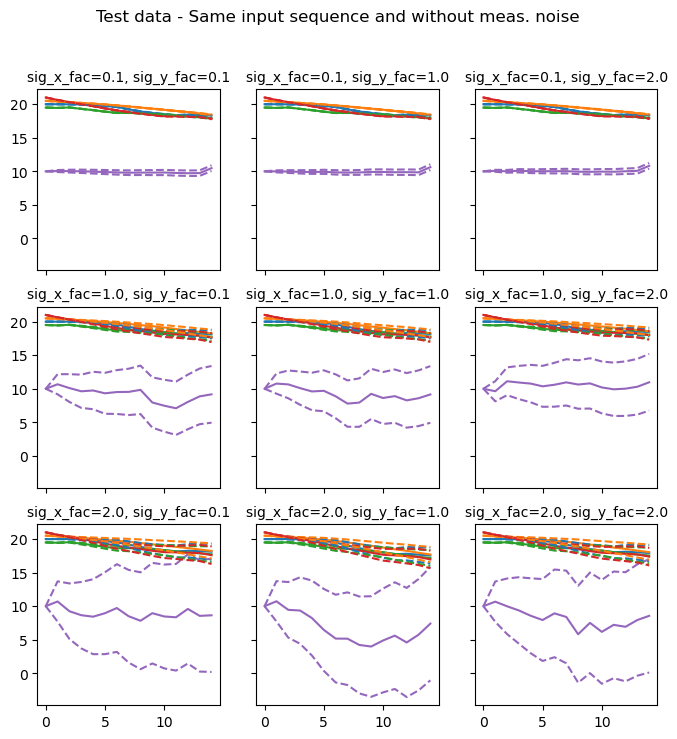

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)

for i, test_data_i in enumerate(test_data):
    k,j = np.unravel_index(i, (3,3))
    std = np.sqrt(np.diagonal(test_data_i.sim_results[0].P, axis1=1, axis2=2))
    
    ax[k,j].plot(test_data_i.sim_results[0].x)
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].x+3*std, linestyle='--')
    ax[k,j].set_prop_cycle(None)
    ax[k,j].plot(test_data_i.sim_results[0].x-3*std, linestyle='--')
    ax[k,j].set_title(f'sig_x_fac={investigations[i][0]}, sig_y_fac={investigations[i][1]}', fontsize=10)

fig.suptitle('Test data - Same input sequence and without meas. noise')


In [26]:
%%capture

results = []


for i, (train_data_i, test_data_i) in enumerate(zip(train_data, test_data)):
    if i==0:
        msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
        ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
    msm.fit(train_data_i)
    ssm.fit(train_data_i)

    y_msm_pred, y_msm_pred_std = msm.predict(test_data_i.M[:,[0]].T, uncert_type="std", with_noise_variance=True)
    y_msm_pred = y_msm_pred.reshape(-1,test_data_i.n_y)
    y_msm_pred_std = y_msm_pred_std.reshape(-1,test_data_i.n_y)
    y_ssm_pred, y_ssm_pred_std = ssm.predict_sequence(test_data_i.M[:,[0]], with_noise_variance=True)

    msm_cov_final = msm.predict(test_data_i.M[:,[0]].T, uncert_type="cov", with_noise_variance=True)[1][-test_data_i.n_y:, -test_data_i.n_y:]

    results.append(
        {
            'y_msm_pred': y_msm_pred,
            'y_msm_pred_std': y_msm_pred_std,
            'y_ssm_pred': y_ssm_pred,
            'y_ssm_pred_std': y_ssm_pred_std,
            'msm_cov_final': msm_cov_final,
        }
    )

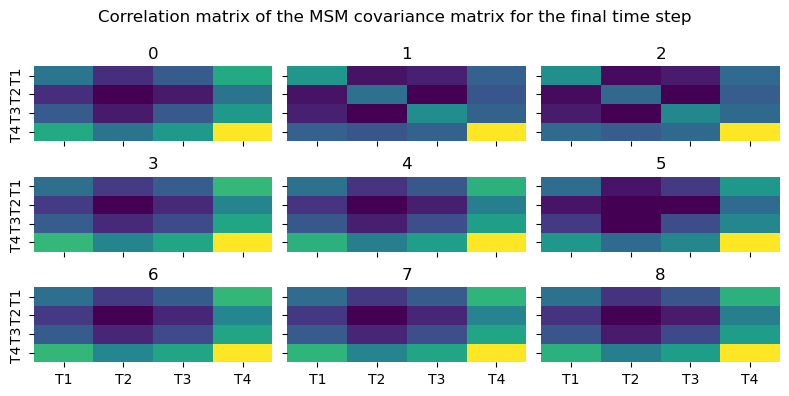

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(8, 4), sharex=True, sharey=True)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))

    names = ['T1', 'T2', 'T3', 'T4']

    if settings['state_feedback']:
        cov = results_i['msm_cov_final'][:-1,:-1]
    else:
        cov = results_i['msm_cov_final']

    corr = pd.DataFrame(cov, index=names, columns=names)

    sns.heatmap(corr, ax=ax[k,j], cmap='viridis', cbar=False)
    ax[k,j].set_title(f'{i}')

fig.suptitle('Correlation matrix of the MSM covariance matrix for the final time step')
fig.tight_layout()

Text(0, 0.5, 'T2')

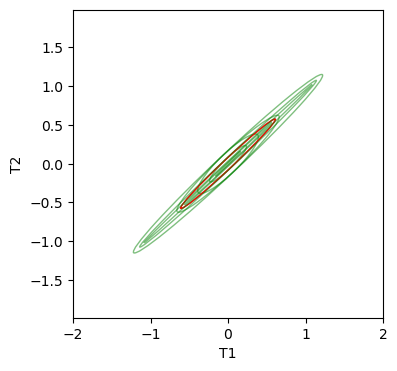

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

ax.axis('equal')

for k in range(len(investigations)):
    cov = results[k]['msm_cov_final']
    helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='g', linewidth=1, alpha=.5)
    if k == 4:
        cov = results[k]['msm_cov_final']
        helper.plot_cov_as_ellipse(0, 0, cov, ax=ax, facecolor='none', edgecolor='r', linewidth=1, alpha=1)


ax.set_xlim(-2, 2)
ax.set_ylim(-2,2)

ax.set_xlabel('T1')
ax.set_ylabel('T2')

In [29]:
def get_plot(result, test_data):
    fig, ax = plt.subplots(test_data.n_y,1, sharex=True, figsize=(10,5))

    t_ini = test_data.setup.T_ini

    y_msm_pred = result['y_msm_pred']
    y_msm_pred_std = result['y_msm_pred_std']
    y_ssm_pred = result['y_ssm_pred']
    y_ssm_pred_std = result['y_ssm_pred_std']

    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data.sim_results],axis=2)

    t = test_data.sim_results[0].time[settings['T_ini']:]
    for i in range(test_data.n_y):
        ax[i].plot(t, Y_pred[:,i,:], color='k',linewidth=1, alpha=0.05)

        ax[i].plot(t, y_ssm_pred[:,i],linewidth=2, label="SSM")
        ax[i].fill_between(t, y_ssm_pred[:,i]-3*y_ssm_pred_std[:,i], y_ssm_pred[:,i]+3*y_ssm_pred_std[:,i], alpha=0.3)

        ax[i].plot(t, y_msm_pred[:,i], '--', linewidth=2, label="MSM")
        ax[i].fill_between(t, y_msm_pred[:,i]-3*y_msm_pred_std[:,i], y_msm_pred[:,i]+3*y_msm_pred_std[:,i], alpha=0.3)

    ax[0].plot([],[], color='k', linewidth=1, alpha=0.2, label="Samples")

    ax[0].legend()

    return fig, ax

Text(0.5, 0.98, '$\\sigma_x$=2.0, $\\sigma_y$=1.0')

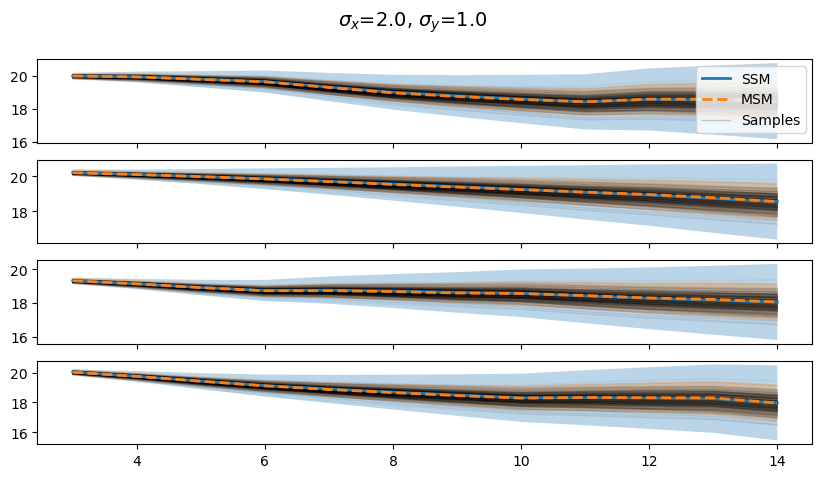

In [30]:
plot_case = 7

fig, ax = get_plot(results[plot_case], test_data[plot_case])
fig.suptitle(f'$\sigma_x$={investigations[plot_case][0]}, $\sigma_y$={investigations[plot_case][1]}', fontsize=14)

In [46]:
def get_normalized_distance(Y_true, y_pred, y_pred_std):
    norm_dist = np.abs(Y_true-np.atleast_3d(y_pred))/np.atleast_3d(y_pred_std)
    return norm_dist

def get_ratio_to_true_std(y_pred_std, true_std):
    ratio = y_pred_std/true_std
    return ratio

def get_stats(Y_true, y_pred, y_pred_std, true_std):
    norm_dist = get_normalized_distance(Y_true, y_pred, y_pred_std)
    in_three_sigma = np.sum(norm_dist < 3)/np.prod(norm_dist.shape)
    # three_sigma_percentile = np.percentile(norm_dist, 99.73, axis=[0,1,2])
    three_sigma_percentile = np.mean(np.percentile(norm_dist, 99.73, axis=[1,2]))
    mse = np.mean((Y_true-np.atleast_3d(y_pred))**2)
    ratio_to_true_std = np.mean(get_ratio_to_true_std(y_pred_std, true_std))

    return in_three_sigma, three_sigma_percentile, mse, ratio_to_true_std

In [48]:
results_post_proc = {
    'msm': {
        'Frac. in 3 sigma': [],
        '99.73 percentile': [],
        'ratio to true std': [],
        'mse': [],
    },
    'ssm': {
        'Frac. in 3 sigma': [],
        '99.73 percentile': [],
        'ratio to true std': [],
        'mse': [],
    },
}

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)
    true_std = (np.sqrt(np.diagonal(test_data_i.sim_results[0].P, axis1=1, axis2=2))@test_data_i.sim_results[0].C.T)[data_gen_setup.T_ini:]

    stats_msm = get_stats(Y_pred, results_i['y_msm_pred'], results_i['y_msm_pred_std'], true_std)
    stats_ssm = get_stats(Y_pred, results_i['y_ssm_pred'], results_i['y_ssm_pred_std'], true_std)

    results_post_proc['msm']['Frac. in 3 sigma'].append(stats_msm[0])
    results_post_proc['msm']['99.73 percentile'].append(stats_msm[1])
    results_post_proc['msm']['mse'].append(stats_msm[2])
    results_post_proc['msm']['ratio to true std'].append(stats_msm[3])
    results_post_proc['ssm']['Frac. in 3 sigma'].append(stats_ssm[0])
    results_post_proc['ssm']['99.73 percentile'].append(stats_ssm[1])
    results_post_proc['ssm']['mse'].append(stats_ssm[2])
    results_post_proc['ssm']['ratio to true std'].append(stats_ssm[3])
    


In [49]:
d1 = pd.DataFrame(results_post_proc['msm'], index=investigations)
d2 = pd.DataFrame(results_post_proc['ssm'], index=investigations)

df = pd.concat([d1,d2], keys=['msm', 'ssm'], axis=1)

df

msm                                               \
           Frac. in 3 sigma 99.73 percentile ratio to true std       mse   
(0.1, 0.1)         1.000000         0.618472          7.821418  0.000178   
(0.1, 1.0)         1.000000         0.546045          9.537485  0.000316   
(0.1, 2.0)         1.000000         0.407965         13.535626  0.000485   
(1.0, 0.1)         0.990486         3.239071          1.198619  0.022585   
(1.0, 1.0)         0.999583         2.572803          1.345566  0.016525   
(1.0, 2.0)         0.998056         2.424633          1.724638  0.017244   
(2.0, 0.1)         0.992361         3.366712          0.932838  0.064398   
(2.0, 1.0)         0.984653         3.886996          1.019153  0.079610   
(2.0, 2.0)         0.999444         2.452921          1.283580  0.069547   

                        ssm                                               
           Frac. in 3 sigma 99.73 percentile ratio to true std       mse  
(0.1, 0.1)         1.000000         0.113223         27.880696  0.000174  
(0.1, 1.0)         1.000000         0.122218         28.424666  0.000277  
(0.1, 2.0)         1.000000         0.162151         32.586501  0.001141  
(1.0, 0.1)         1.000000         0.931473          3.868882  0.020532  
(1.0, 1.0)         1.000000         1.048721          3.054750  0.017347  
(1.0, 2.0)         1.000000         0.985008          3.367888  0.015120  
(2.0, 0.1)         1.000000         1.456096          2.159822  0.064660  
(2.0, 1.0)         0.999514         2.269317          1.768414  0.079312  
(2.0, 2.0)         1.000000         1.595233          1.857664  0.062310

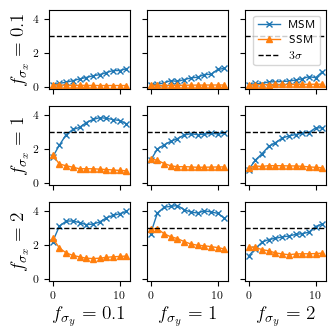

In [64]:
fig, ax = plt.subplots(3, 3, figsize=(config_mpl.columnwidth, config_mpl.columnwidth), sharex=True, sharey=True)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))
    
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)
    norm_dist_msm = get_normalized_distance(Y_pred, results_i['y_msm_pred'], results_i['y_msm_pred_std'])
    norm_dist_ssm = get_normalized_distance(Y_pred, results_i['y_ssm_pred'], results_i['y_ssm_pred_std'])

    three_sigma_percentile_msm = np.percentile(norm_dist_msm, 99.73, axis=[1,2])
    three_sigma_percentile_ssm = np.percentile(norm_dist_ssm, 99.73, axis=[1,2])
    
    ax[k,j].plot(three_sigma_percentile_msm, '-x', label='MSM')
    ax[k,j].plot(three_sigma_percentile_ssm, '-^', label='SSM')    
    ax[k,j].axhline(3, color='k', linestyle='--', label='$3\sigma$')



ax[0,0].set_ylabel('$f_{\sigma_x} = 0.1$')
ax[1,0].set_ylabel('$f_{\sigma_x} = 1$')
ax[2,0].set_ylabel('$f_{\sigma_x} = 2$')

ax[2,0].set_xlabel('$f_{\sigma_y} = 0.1$')
ax[2,1].set_xlabel('$f_{\sigma_y} = 1$')
ax[2,2].set_xlabel('$f_{\sigma_y} = 2$')

ax[0,2].legend()
fig.tight_layout()

In [55]:
Y_pred.shape

np.atleast_3d(true_std)

get_ratio_to_true_std(results_i['y_msm_pred'], true_std).shape

(12, 4)

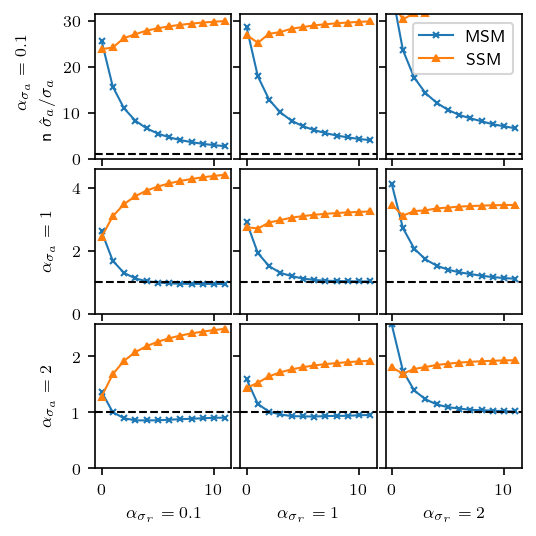

In [76]:

fig, ax = plt.subplots(3, 3, figsize=(config_mpl.columnwidth, config_mpl.columnwidth), sharex=True, sharey='row', dpi=150)

for i, (test_data_i, results_i) in enumerate(zip(test_data, results)):
    k,j = np.unravel_index(i, (3,3))
    
    Y_pred = np.stack([sample.y[settings['T_ini']:] for sample in test_data_i.sim_results],axis=2)

    true_std = (np.sqrt(np.diagonal(test_data_i.sim_results[0].P, axis1=1, axis2=2))@test_data_i.sim_results[0].C.T)[data_gen_setup.T_ini:]
    mean_ratio_true_std_msm = np.mean(get_ratio_to_true_std(results_i['y_msm_pred_std'], true_std), axis=1)
    mean_ratio_true_std_ssm = np.mean(get_ratio_to_true_std(results_i['y_ssm_pred_std'], true_std), axis=1)

    
    ax[k,j].plot(mean_ratio_true_std_msm, '-x', label='MSM', markersize=3)
    ax[k,j].plot(mean_ratio_true_std_ssm, '-^', label='SSM', markersize=3)    
    ax[k,j].axhline(1, color='k', linestyle='--')

    ax[k,j].set_ylim(0, None)



ax[0,0].set_ylabel(r'$\alpha_{\sigma_a} = 0.1$\\  $\hat \sigma_a / \sigma_a$')
ax[1,0].set_ylabel(r'$\alpha_{\sigma_a} = 1$')
ax[2,0].set_ylabel(r'$\alpha_{\sigma_a} = 2$')

ax[2,0].set_xlabel(r'$\alpha_{\sigma_r} = 0.1$')
ax[2,1].set_xlabel(r'$\alpha_{\sigma_r} = 1$')
ax[2,2].set_xlabel(r'$\alpha_{\sigma_r} = 2$')

ax[0,2].legend()


fig.tight_layout(pad = 0.1)
fig.align_labels()

savepath = os.path.join('..', '..', '2023_CDC_L-CSS_Paper_Stochastic_MSM', 'figures')
savename = 'ratio_ident_vs_true_std'
# fig.savefig(os.path.join(savepath, savename + '.pgf'), bbox_inches='tight', format='pgf')

## Export model

In [67]:
%%capture

export_id = 4

train_data_i = train_data[export_id]
msm = sid.MultistepModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
ssm = sid.StateSpaceModel(estimate_covariance=True, scale_x=False, scale_y=False, add_bias=True)
msm.fit(train_data_i)
ssm.fit(train_data_i)

sig_x_fac_i, sig_y_fac_i = investigations[export_id]
sigma_x=base_sig_x*sig_x_fac_i
sigma_y=base_sig_y*sig_y_fac_i


In [70]:
result_dir = os.path.join('sid_results')
save_name = "building_prediction_models.pkl"
save_name = os.path.join(result_dir, save_name)

pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)

with open(save_name, "wb") as f:
    res = {'msm': msm, 'ssm': ssm, 'sigma_x': sigma_x, 'sigma_y': sigma_y}
    pickle.dump(res, f)

Check if loading works

In [71]:
with open(save_name, "rb") as f:
    res = pickle.load(f)